<a href="https://colab.research.google.com/github/lautitorraca/7506R-2C2023-GRUPO24/blob/main/TP1/7506R_TP1_GRUPO24_CHP3_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install 'dtreeviz'
!pip install scikit-learn-intelex


In [66]:
import pandas as pd
import numpy as np

from sklearnex import patch_sklearn

patch_sklearn()

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
    recall_score,
    f1_score,
    precision_score,
)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz.trees as dtreeviz

# Modelos y métricas
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#Download
from google.colab import files

# Configuración de advertencias
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [67]:

# url_train = 'https://raw.githubusercontent.com/lautitorraca/7506R-2C2023-GRUPO24/main/TP1/DataSets/df_train_limpio.csv'
# url_test = 'https://raw.githubusercontent.com/lautitorraca/7506R-2C2023-GRUPO24/main/TP1/DataSets/df_test_limpio.csv'

url_train = '/content/df_train_limpio.csv'
url_test = '/content/df_test_limpio.csv'

ds_train_base = pd.read_csv(url_train)
ds_test_base = pd.read_csv(url_test)

ds_test = ds_test_base.copy()
df_test = pd.DataFrame(ds_test_base)

ds_train = ds_train_base.copy()
df_train = pd.DataFrame(ds_train_base)

In [68]:
print(df_train.shape)
print(df_test.shape)

(61913, 52)
(26535, 52)


In [69]:
# features = ['lead_time_category','booking_changes','required_car_parking_spaces','total_of_special_requests','room_type_match','cancel_to_noncancel_ratio', 'is_repeated_guest',
#              'previous_cancellations','country', 'market_segment', 'deposit_type', 'distribution_channel', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adr',
#              'adults','children','babies', 'days_in_waiting_list_category','customer_type','hotel','is_canceled','id']

# columns_to_dum= ['lead_time_category','hotel', 'country', 'market_segment', 'deposit_type', 'distribution_channel', 'days_in_waiting_list_category', 'customer_type']



# # columna_a_eliminar_test = 'reservation_status_date'
# # df_test.drop(columna_a_eliminar_test, axis='columns', inplace = True)
# df_test.insert(1, 'is_canceled', " ")

# df_trabajo_train = df_train[features]
# df_trabajo_train_dum = pd.get_dummies(df_trabajo_train, columns = columns_to_dum)
# df_trabajo_train_dum = pd.DataFrame(df_trabajo_train_dum)

# df_trabajo_test = df_test[features]
# df_trabajo_test_dum = pd.get_dummies(df_trabajo_test, columns = columns_to_dum)
# df_trabajo_test_dum = pd.DataFrame(df_trabajo_test_dum)

df_trabajo_train_dum = df_train
df_trabajo_test_dum = df_test



### KNN

In [70]:
from sklearn.model_selection import train_test_split

X = df_trabajo_train_dum.drop(['is_canceled', 'id'], axis=1) # 'columna_resultado' es la columna que quieres predecir
y = df_trabajo_train_dum['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("NaN en X_train:", X_train.isnull().sum().sum())
print("NaN en y_train:", y_train.isnull().sum())

# Verificar el tipo de datos
print("Tipo de X_train:", type(X_train))
print("Tipo de y_train:", type(y_train))

# Convertir y_train a numpy array si es una Serie
if isinstance(y_train, pd.Series):
    y_train = y_train.values

# Verificar dimensiones
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)

NaN en X_train: 0
NaN en y_train: 0
Tipo de X_train: <class 'pandas.core.frame.DataFrame'>
Tipo de y_train: <class 'pandas.core.series.Series'>
Dimensiones de X_train: (49530, 50)
Dimensiones de y_train: (49530,)


In [71]:
X_train = X_train.to_numpy()
y_train = y_train
X_test = X_test.to_numpy()

metrics = []

k_range = range(19, 20)

for n in k_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

In [72]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(20,30),
              'weights':['distance'],
              'algorithm':['kd_tree'],
              'metric':['minkowski']}


#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=22)

rand.fit(X_train, y_train)
rand.cv_results_['mean_test_score']

print('best params: ',rand.best_params_)

print('best score: ',rand.best_score_)

best params:  {'weights': 'distance', 'n_neighbors': 28, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
best score:  0.536856598371355


Mejores hiperparámetros:  {'weights': 'distance', 'n_neighbors': 27, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
best params:  {'weights': 'distance', 'n_neighbors': 27, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
best score:  0.8200656794820416

In [73]:
best_knn=rand.best_estimator_

y_pred = best_knn.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1-Score en el conjunto de prueba con las características seleccionadas: {f1:.4f}")

F1-Score en el conjunto de prueba con las características seleccionadas: 0.5403


Text(50.722222222222214, 0.5, 'True')

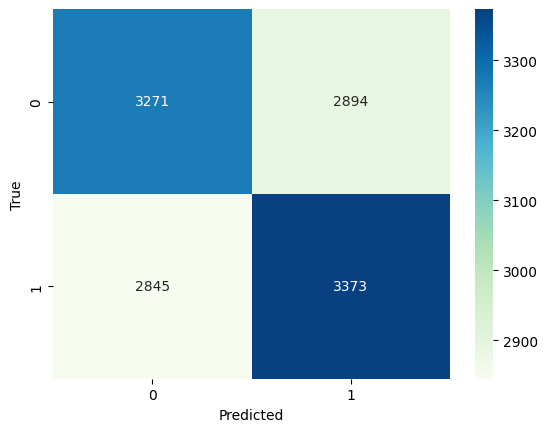

In [74]:
tabla1 = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla1,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')


In [75]:
def mostrar_metricas(y_test, y_pred):
    accuracy=accuracy_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

In [76]:
mostrar_metricas(y_test, y_pred)

Accuracy: 0.5365420334329323
Recall: 0.5424573817947893
Precision: 0.5382160523376416
f1 score: 0.5403283940728875


In [77]:

# df_knn = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
# ids1 = df_trabajo_test_dum['id'].copy()

# pred_knn = best_knn.predict(df_knn)

# df_pred_knn = pd.DataFrame({'id': ids1, 'is_canceled': pred_knn})

# df_pred_knn.to_csv('df_pred_knn.csv')
# files.download('df_pred_knn.csv')


### SVM

In [78]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [79]:
from sklearn import preprocessing
#Armo una version escalada con minmax (media=0 , var=1  )
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(X_train)
x_test_minmax  = min_max_scaler.transform(X_test)

#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(X_train)
x_test_norm=stand_scaler.transform(X_test)

              precision    recall  f1-score   support

           0       0.50      0.82      0.62      6165
           1       0.50      0.18      0.27      6218

    accuracy                           0.50     12383
   macro avg       0.50      0.50      0.44     12383
weighted avg       0.50      0.50      0.44     12383



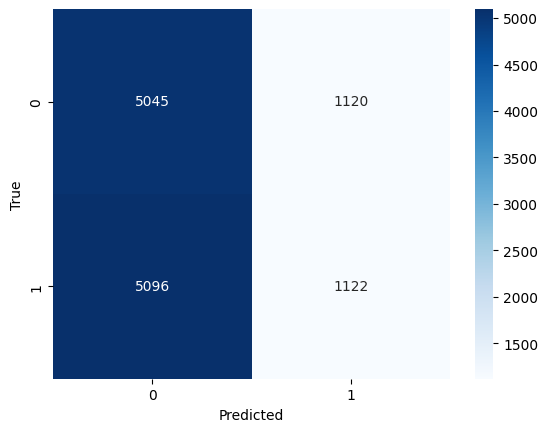

In [80]:
#Construyo un modelo SVM
svm = SVC()

#Lo entreno con los datos sin escalar
svm.fit(X_train, y_train)

#Hago la prediccion y calculo las métricas
y_pred1=svm.predict(X_test)
metricas(y_pred1,y_test)

In [81]:
mostrar_metricas(y_test, y_pred1)

Accuracy: 0.4980214810627473
Recall: 0.1804438726278546
Precision: 0.5004460303300624
f1 score: 0.2652482269503546


              precision    recall  f1-score   support

           0       0.85      0.84      0.84      6165
           1       0.84      0.85      0.85      6218

    accuracy                           0.84     12383
   macro avg       0.84      0.84      0.84     12383
weighted avg       0.84      0.84      0.84     12383



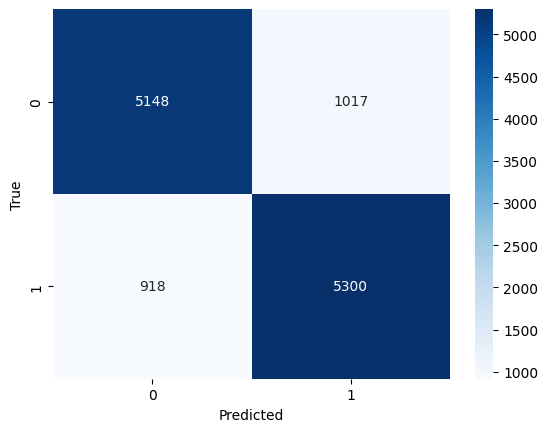

In [82]:
#Construyo un modelo SVM
svm_norm= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
y_pred_norm1=svm_norm.predict(x_test_norm)
metricas(y_pred_norm1,y_test)

In [83]:
mostrar_metricas(y_test, y_pred_norm1)

Accuracy: 0.8437373818945328
Recall: 0.8523641042135734
Precision: 0.8390058572107013
f1 score: 0.8456322297566813


SVM - Kernels

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      6165
           1       0.80      0.84      0.82      6218

    accuracy                           0.82     12383
   macro avg       0.82      0.82      0.82     12383
weighted avg       0.82      0.82      0.82     12383



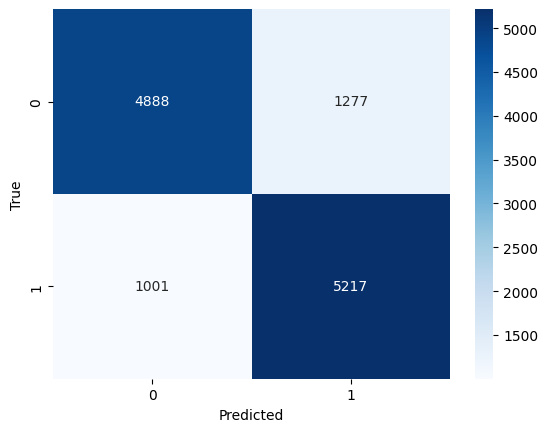

In [84]:
#Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='linear', C=5)
clf.fit(x_train_minmax, y_train)

#Hago la predicción y calculo las métricas
y_pred_lin=clf.predict(x_test_minmax)
metricas(y_pred_lin,y_test)

In [85]:
mostrar_metricas(y_test, y_pred_lin)

Accuracy: 0.8160381167729952
Recall: 0.8390157606947571
Precision: 0.8033569448721897
f1 score: 0.8207992448080553


SVM con kernel POLINOMICO

In [86]:
# #Creo un clasificador con kernel polinomico y lo entreno sobre los datos escalados min-max
# clf = SVC(kernel='poly', C=5, degree=10, gamma=10, coef0=10)
# clf.fit(x_train_minmax, y_train)

# #Hago la predicción y calculo las métricas
# y_pred_pol=clf.predict(x_test_minmax)
# metricas(y_pred_pol,y_test)

In [87]:
# mostrar_metricas(y_test, y_pred_pol)

**SVM con kernel RADIAL**

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      6165
           1       0.83      0.80      0.81      6218

    accuracy                           0.82     12383
   macro avg       0.82      0.82      0.82     12383
weighted avg       0.82      0.82      0.82     12383



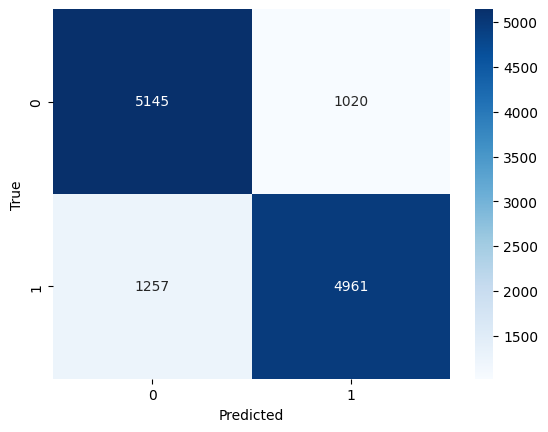

In [88]:
#Creo un clasificador con kernel radial y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='rbf', C=5, gamma=10)
clf.fit(x_train_minmax, y_train)

#Hago la predicción y calculo las métricas
y_pred_rad=clf.predict(x_test_minmax)
metricas(y_pred_rad,y_test)

In [89]:
mostrar_metricas(y_test, y_pred_rad)

Accuracy: 0.8161188726479851
Recall: 0.7978449662270827
Precision: 0.8294599565290085
f1 score: 0.8133453561767359


### ENSAMBLES

### RF - KFOLD CROSSVALIDATION

In [90]:
rfc = RandomForestClassifier(max_features='auto',
                             oob_score=True,
                             random_state=2,
                             n_jobs=-1,
                             criterion="entropy",
                             min_samples_leaf=5,
                             min_samples_split=5,
                             n_estimators=50 )
#Entrenamos el modelo
model = rfc.fit(X = X_train, y = y_train)

In [91]:
y_predRF = model.predict(X_test)

Text(50.722222222222214, 0.5, 'True')

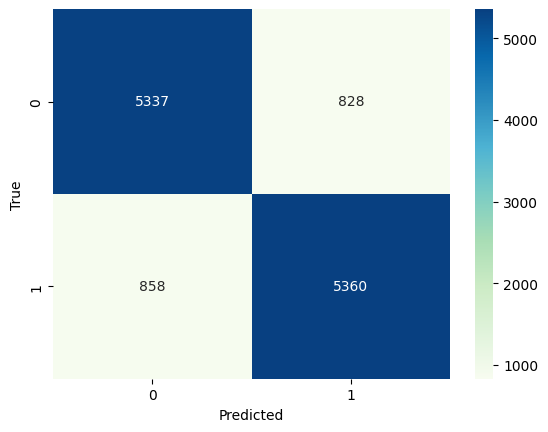

In [92]:
tabla=confusion_matrix(y_test, y_predRF)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [93]:
mostrar_metricas(y_test,y_predRF)

Accuracy: 0.8638455947670193
Recall: 0.8620135091669348
Precision: 0.8661926308985133
f1 score: 0.8640980170885055


In [94]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 5, 10],
               "min_samples_split" : [2, 4, 10, 12, 16],
               "n_estimators": [10,20, 50] }

gs = RandomizedSearchCV(estimator=rf_cv, param_distributions=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs_fit = gs.fit(X = X_train, y = y_train)

In [95]:
gs_fit.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'criterion': 'gini'}

In [96]:
print("F1 en entrenamiento con cv: "+str(gs_fit.best_score_))

F1 en entrenamiento con cv: 0.864641195935824


In [97]:
rf_cv_best=gs_fit.best_estimator_

y_pred_rf_cv_best = rf_cv_best.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      6165
           1       0.87      0.86      0.87      6218

    accuracy                           0.87     12383
   macro avg       0.87      0.87      0.87     12383
weighted avg       0.87      0.87      0.87     12383



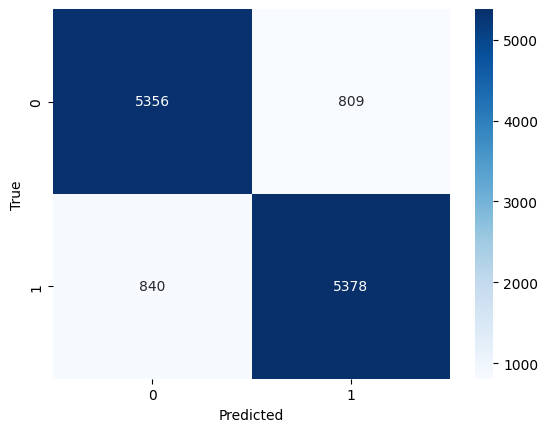

In [98]:
tabla=confusion_matrix(y_test,y_pred_rf_cv_best)

sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred_rf_cv_best))

In [99]:
mostrar_metricas(y_test,y_pred_rf_cv_best)

Accuracy: 0.8668335621416458
Recall: 0.864908330652943
Precision: 0.8692419589461775
f1 score: 0.8670697299476018


In [100]:

# df_rf = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
# ids2 = df_trabajo_test_dum['id'].copy()

# pred_rf = rf_cv_best.predict(df_rf)

# df_pred_rf = pd.DataFrame({'id': ids2, 'is_canceled': pred_rf})

# df_pred_rf.to_csv('df_pred_rf.csv')
# files.download('df_pred_rf.csv')

### XGBOOST

In [101]:

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2]
}

xgb_model = XGBClassifier()

n_iter_search = 40

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=n_iter_search, scoring='f1', cv=3, verbose=1)
random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [102]:

best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

AUC: 0.95004539055047
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      6165
           1       0.86      0.88      0.87      6218

    accuracy                           0.87     12383
   macro avg       0.87      0.87      0.87     12383
weighted avg       0.87      0.87      0.87     12383



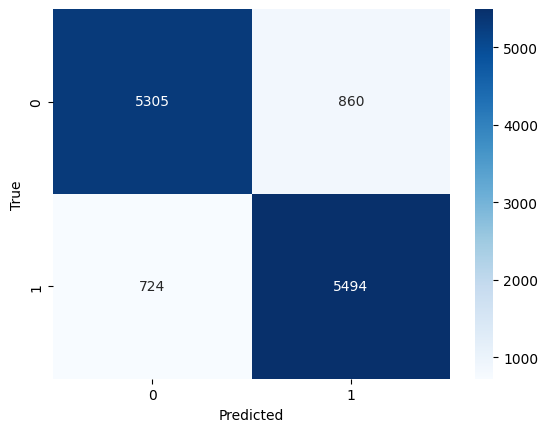

In [103]:

y_pred_proba= best_xgb.predict_proba(X_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

y_predxgboost=best_xgb.predict(X_test)

cm = confusion_matrix(y_test,y_predxgboost)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_predxgboost))


In [104]:
mostrar_metricas(y_test,y_predxgboost)

Accuracy: 0.8720826940159897
Recall: 0.8835638468961081
Precision: 0.8646521875983633
f1 score: 0.8740057270124084


In [105]:
data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.1},num_boost_round=8,metrics='auc')
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.888650,0.000871,0.887574,0.003194
1,0.890229,0.000755,0.889118,0.003674
2,0.893789,0.000944,0.892690,0.004696
3,0.897277,0.001336,0.896295,0.002825
4,0.902905,0.001431,0.901518,0.004848
5,0.905163,0.001692,0.903831,0.005000
6,0.907594,0.001321,0.906191,0.004578
7,0.910165,0.001303,0.908918,0.004064


In [106]:
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.2},num_boost_round=8,metrics='auc',seed=0)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.888650,0.000871,0.887574,0.003194
1,0.894547,0.001255,0.893480,0.005316
2,0.901669,0.000916,0.900518,0.004289
3,0.908664,0.001405,0.907729,0.002068
4,0.911558,0.002160,0.910527,0.001572
5,0.914470,0.001577,0.913215,0.001376
6,0.917199,0.001703,0.915733,0.001790
7,0.918737,0.001591,0.917338,0.001843


In [107]:
from google.colab import files
df_xgb = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
ids3 = df_trabajo_test_dum['id'].copy()

pred_xgb = best_xgb.predict(df_xgb)

df_pred_xgb = pd.DataFrame({'id': ids3, 'is_canceled': pred_xgb})

df_pred_xgb.to_csv('df_pred_xgb.csv')
files.download('df_pred_xgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ensamble STACKING

In [108]:
#Creo un conjunto de datos para entrenar los modelos
x, y = make_classification(n_samples=3000,
                           n_features=20,
                           n_informative=15,
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)

In [109]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [110]:
#Funcion para plotear a performance
def plot_results(model_scores, name):

    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )

    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [111]:
#Modelos Base
base_models = {'random_forest':RandomForestClassifier(n_estimators=50),
               'svm': SVC(),
               'knn': KNeighborsClassifier(n_neighbors=11)}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, X_train, y_train)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   34.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating svm


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  7.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating knn


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   24.2s finished


In [112]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors=11))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)

In [113]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, X_train, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 38.0min finished


In [114]:
#Evaluo en conjunto de test

stacking_model.fit(X_train,y_train)
y_pred_st = stacking_model.predict(X_test)
accuracy_score(y_test, y_pred_st)

0.8543971573932003

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      6165
           1       0.87      0.83      0.85      6218

    accuracy                           0.85     12383
   macro avg       0.86      0.85      0.85     12383
weighted avg       0.86      0.85      0.85     12383



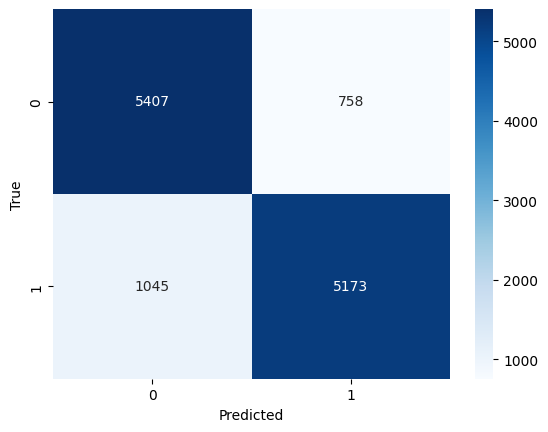

In [115]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_st)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_st))

In [116]:
mostrar_metricas(y_test,y_pred_st)

Accuracy: 0.8543971573932003
Recall: 0.8319395303956256
Precision: 0.872196931377508
f1 score: 0.8515927236809614


In [117]:
# df_stacking = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
# ids4 = df_trabajo_test_dum['id'].copy()

# pred_stacking = stacking_model.predict(df_stacking)

# df_pred_stacking = pd.DataFrame({'id': ids4, 'is_canceled': pred_stacking})

# df_pred_stacking.to_csv('df_pred_stacking.csv')
# files.download('df_pred_stacking.csv')

#VOTING

In [118]:
#Creo un conjunto de datos para entrenar los modelos

x, y = make_classification(n_samples=3000,
                           n_features=20,
                           n_informative=15,
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)

In [119]:
#Creo clasificadores

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size = 0.3)

#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
y_pred_voting = vot_clf.predict(x_test)
accuracy_score(y_test, y_pred_voting)

0.7977777777777778

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       440
           1       0.82      0.77      0.80       460

    accuracy                           0.80       900
   macro avg       0.80      0.80      0.80       900
weighted avg       0.80      0.80      0.80       900



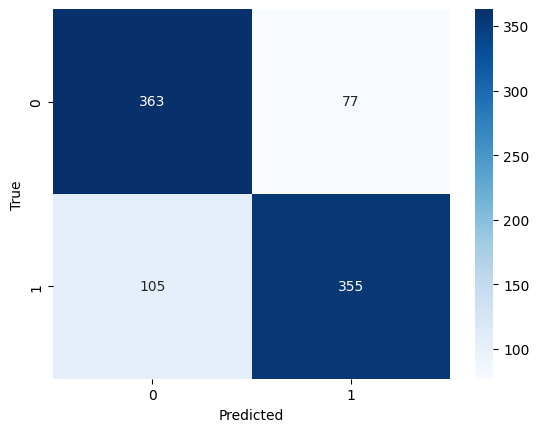

In [120]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_voting)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_voting))

In [121]:
mostrar_metricas(y_test,y_pred_voting)

Accuracy: 0.7977777777777778
Recall: 0.7717391304347826
Precision: 0.8217592592592593
f1 score: 0.7959641255605381


In [122]:

# df_voting = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
# ids5 = df_trabajo_test_dum['id'].copy()

# pred_voting = vot_clf.predict(df_voting)

# df_pred_voting = pd.DataFrame({'id': ids5, 'is_canceled': pred_voting})

# df_pred_voting.to_csv('df_pred_voting.csv')
# files.download('df_pred_voting.csv')
